# ML - Supervised - Classification - RandomForest

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sqlite3
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import train_test_split as TTS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RF

## Labelised Data

### DataSets: Fraud_Data.csv & IpAddress_to_Country 

In [2]:
df1 = pd.read_csv('Fraud_Data.csv')
df1

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0


In [3]:
df2 = pd.read_csv('IpAddress_to_Country.csv')
df2

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [4]:
#Cette solution à été sauvegardé sous 'save.csv' car très longue

#conn = sqlite3.connect(":memory:") 
#df1.to_sql("df1", conn, index=False)
#df2.to_sql("df2", conn, index=False)
#qry = "SELECT * FROM df1, df2 WHERE df1.ip_address >= df2.lower_bound_ip_address and df1.ip_address <= df2.upper_bound_ip_address"
#df3 = pd.read_sql_query(qry,conn)
#df3

In [5]:
#autre solution

#def IP_to_country(ip) :
#    try :
#        return df2.country[(df2.lower_bound_ip_address <= ip)
#                                & 
#                                (df2.upper_bound_ip_address >= ip)].iloc[0]
#    except IndexError :
#        return "Unknown"

#df1["country"] = df1.ip_address.apply(IP_to_country)

In [6]:
#autre solution

#voir pandasql

In [7]:
df3 = pd.read_csv('save.csv')
df3

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,7.298089e+08,734003199,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,3.355443e+08,352321535,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2.621440e+09,2621505535,United States
3,3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4.154982e+08,415629311,United States
4,4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,2.809266e+09,2809331711,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129141,129141,360761,2015-02-10 06:39:44,2015-06-03 08:18:30,13,EFCFFMUKFRDHJ,SEO,Safari,F,42,8.740657e+08,0,8.724152e+08,889192447,United States
129142,129142,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,3.451126e+09,3451387903,United States
129143,129143,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,2.436039e+09,2441084927,Netherlands
129144,129144,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,2.748449e+09,2748514303,Japan


### Cleaning

In [8]:
#drop unwanted columns
df = df3.drop(columns=['lower_bound_ip_address', 'upper_bound_ip_address', 'user_id'])

In [9]:
le = LE()
df['source'] = le.fit_transform(df['source'])
df['browser'] = le.fit_transform(df['browser'])
df['sex'] = le.fit_transform(df['sex'])
df['country'] = le.fit_transform(df['country'])
df['device_id'] = le.fit_transform(df['device_id'])

#a clean:

#df['signup_time']
#df['purchase_time']

#en attendant
df = df.drop(columns=['signup_time', 'purchase_time'])

In [10]:
df.isnull().values.any()

False

### Isolation

In [11]:
#Isolation
#target_feature_name = 'target_feature'
target_feature_name = 'class'
Y = df[target_feature_name]
X = df.drop(columns=target_feature_name)

### Labels

In [12]:
#Classes/Labels
classes = Y.astype('category').cat.categories.tolist()
df3['country_code'] = df['country']
country_labels_df = df3[['country', 'country_code']]
country_labels = country_labels_df.groupby(by='country').mean().to_dict();
country_labels = country_labels['country_code']
#country_labels
def code2country(i):
    return list(country_labels.keys())[i]

## Model Building

In [13]:
#TTS
X_tr, X_te, Y_tr, Y_te = TTS(X, Y, stratify=Y, random_state=314)

In [14]:
#Pipeline
pipeline_details = [('PCA', PCA(random_state=20)),
                    ('RF', RF())]
pipeline = Pipeline(steps=pipeline_details)

In [15]:
#GridSearchCV
#limité pour cause de performance


hyperparameters = {}
#hyperparameters['PCA__n_components'] = [i for i in range(1, 5)]
#hyperparameters['RF__n_estimators']  = [i for i in range(80, 120 +1, 10)]
hyperparameters['PCA__n_components'] = [5]
hyperparameters['RF__n_estimators']  = [100]

In [16]:
hyperparameters

{'PCA__n_components': [5], 'RF__n_estimators': [100]}

In [17]:
hyperparameter_search = GridSearchCV(pipeline,
                                     hyperparameters,
                                     scoring='accuracy', 
                                     cv=3)

In [18]:
hyperparameter_search.fit(X_tr, Y_tr)

print('Meilleur score : {:.5f}'.format(hyperparameter_search.best_score_))
print('Meilleur paramètres : {}'.format(hyperparameter_search.best_params_))

Meilleur score : 0.93146
Meilleur paramètres : {'PCA__n_components': 5, 'RF__n_estimators': 100}


In [19]:
#PCA
N=hyperparameter_search.best_params_['PCA__n_components']
pca = PCA(n_components=N, random_state=20)
pca.fit(X_tr);

In [20]:
#Transform
X_tr_PCA = pca.transform(X_tr)
X_te_PCA = pca.transform(X_te)

In [23]:
#RF
N=hyperparameter_search.best_params_['RF__n_estimators']
rf = RF(n_estimators=N)
rf.fit(X_tr_PCA, Y_tr);

In [24]:
#Accuracy du training
train_preds = rf.predict(X_tr_PCA)
accuracy = lambda p, y : (p==y).sum()/len(y)
print('Accuracy : {}'.format(accuracy(train_preds, Y_tr)))

Accuracy : 0.9999277299992773


## Unlabelised Data

In [25]:
#Chargement
#df = pd.read_csv("data/filename.csv")
unlabeled_df = pd.DataFrame(X_te_PCA)

### Prediction

In [26]:
#RF
preds = rf.predict(unlabeled_df)
proba = rf.predict_proba(unlabeled_df)

## Result

In [27]:
labeled_df = pd.DataFrame(X_te)
labeled_df['Predictions'] = preds
for i in range(0, len(proba[0])):
    labeled_df[classes[i]] = proba[:, i]

#for k in range(0, len(proba)):
#    print('iris[', k, ']')
#    for i in range(0, len(proba[0])):
#        print('{} {}= {}'.format(classes[i], (10-len(classes[i]))*' ', proba[k][i]))

labeled_df = labeled_df.drop(columns='Unnamed: 0')

## Matrice de confusion

In [28]:
from sklearn.metrics import confusion_matrix
def show_cm(cm, labels):
    """show confusion matrix
    """
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

Matrice de confusion de l'entrainement :
Accuracy : 0.9999277299992773


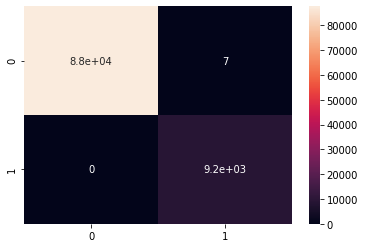

In [29]:
print("Matrice de confusion de l'entrainement :")
print('Accuracy : {}'.format(accuracy(train_preds, Y_tr)))
cm_train = confusion_matrix(train_preds, Y_tr, labels=classes)
show_cm(cm_train, classes)
#Accuracy du training
accuracy = lambda p, y : (p==y).sum()/len(y)

Matrice de confusion du test :
Accuracy : 0.9390466751324062


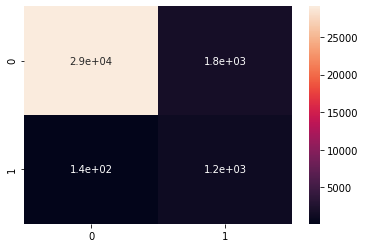

In [30]:
print("Matrice de confusion du test :")
print('Accuracy : {}'.format(accuracy(preds, Y_te)))
cm_test = confusion_matrix(preds, Y_te, labels=classes)
show_cm(cm_test, classes)
#Accuracy du test
accuracy = lambda p, y : (p==y).sum()/len(y)

## Pouvoir prédictif des features

In [31]:
rf = RF(n_estimators=100)
rf.fit(X_tr.drop(columns='Unnamed: 0'), Y_tr)
importances = rf.feature_importances_

Somme des pouvoirs predictif : 1.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


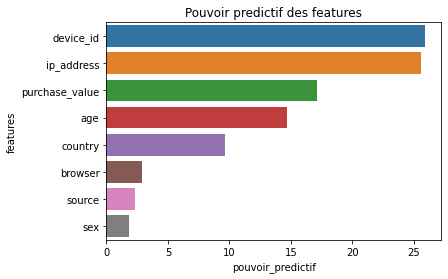

In [32]:
d = pd.DataFrame()
d['features'] = X_tr.drop(columns='Unnamed: 0').columns
d['pouvoir_predictif'] = importances
#for i in range (0, len(importances)):
#    print('{}{} : {}'.format(X_tr.columns[i], ' '*(30-len(X_tr.columns[i])), importances[i]))
print('Somme des pouvoirs predictif : {}'.format(d['pouvoir_predictif'].sum()))
d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
d = d.sort_values(by='pouvoir_predictif', ascending=False)
sns.barplot(d['pouvoir_predictif'], d['features']).set_title('Pouvoir predictif des features');

### Les 3 features impactant le plus le model sont :
    -device_id
    -ip_address
    -purchase_value

## Fraudes par pays

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


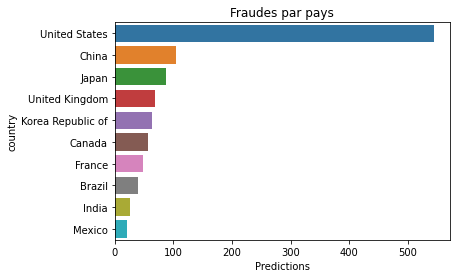

In [33]:
grouped = labeled_df[['country', 'Predictions']].groupby(by='country', as_index=False).sum().sort_values('Predictions', ascending=False)
grouped['country'] = grouped['country'].apply(lambda i : code2country(i))
top10 = grouped[0:10]
sns.barplot(top10['Predictions'], top10['country']).set_title('Fraudes par pays');

### Les Etats-Unis (562) sont loins devant, suivi par la Chine (99) et le Japon (84). 

# ROC curve & AUC score
### https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [73]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

In [41]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_te, proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [45]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_te.ravel(), proba[:, i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

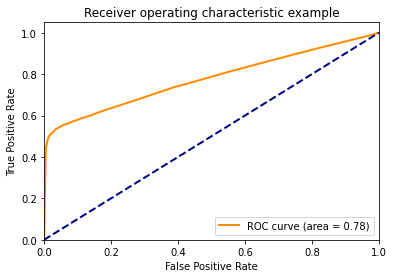

In [61]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [71]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


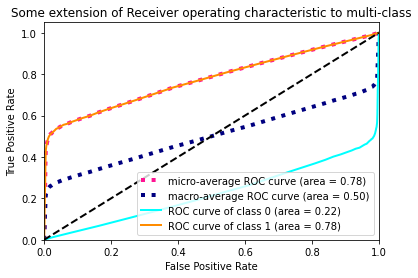

In [74]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()